# imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
assert tf.__version__ >= "2.0"

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# ignore convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")

2024-05-01 19:30:08.888502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# data importation

In [2]:
closures = pd.read_csv("CMU Closures.csv")
weather_1 = pd.read_csv("CMU (primary station).csv")
missing_1 = pd.read_csv("CMU (secondary station - part 1).csv")
missing_2 = pd.read_csv("CMU (secondary station - part 2).csv", dtype=str)

print(closures.info(), weather_1.info(), missing_1.info(), missing_2.info())
#154 expected closures
#21365 weather data points

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATE          29 non-null     object
 1   Closure Type  29 non-null     object
dtypes: object(2)
memory usage: 596.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15157 entries, 0 to 15156
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          15157 non-null  object 
 1   NAME             15157 non-null  object 
 2   LATITUDE         15157 non-null  float64
 3   LONGITUDE        15157 non-null  float64
 4   ELEVATION        15157 non-null  float64
 5   DATE             15157 non-null  object 
 6   DAPR             5 non-null      float64
 7   DAPR_ATTRIBUTES  5 non-null      object 
 8   MDPR             6 non-null      float64
 9   MDPR_ATTRIBUTES  6 non-null      object 
 10  MDSF             1 

# data pre-processing - date/time

In [3]:
weather_1['DATE'] = pd.to_datetime(weather_1['DATE'], dayfirst = True, format= '%m/%d/%y')
missing_1['DATE'] = pd.to_datetime(missing_1['DATE'], dayfirst = True, format= '%m/%d/%y' )
missing_2['DATE'] = pd.to_datetime(missing_2['DATE'], yearfirst = True, format= '%Y-%m-%d')
closures['DATE'] = pd.to_datetime(closures['DATE'], format = '%m/%d/%y')

print(weather_1['DATE'].value_counts(), missing_1['DATE'].value_counts(), missing_2['DATE'].value_counts(), closures['DATE'].value_counts())

DATE
1975-01-01    1
2008-03-12    1
2007-05-31    1
2008-03-01    1
2008-03-02    1
             ..
1989-02-05    1
1989-02-06    1
1989-02-07    1
1989-02-08    1
2024-02-04    1
Name: count, Length: 15157, dtype: int64 DATE
2006-11-01    1
2006-12-02    1
2006-12-04    1
2006-12-05    1
2006-12-06    1
             ..
2006-11-26    1
2006-11-27    1
2006-11-28    1
2006-11-29    1
2006-12-31    1
Name: count, Length: 61, dtype: int64 DATE
2007-06-01    1
2007-11-12    1
2007-11-14    1
2007-11-15    1
2007-11-16    1
             ..
2007-09-01    1
2007-09-02    1
2007-09-03    1
2007-09-04    1
2008-02-29    1
Name: count, Length: 262, dtype: int64 DATE
1975-04-03    1
2014-02-21    1
2023-02-28    1
2023-02-27    1
2023-02-23    1
2023-02-22    1
2022-03-30    1
2022-03-07    1
2021-02-05    1
2019-02-07    1
2019-01-31    1
2019-01-30    1
2019-01-28    1
2017-01-12    1
2014-01-28    1
1978-01-26    1
2013-02-08    1
2011-03-23    1
2011-02-21    1
2011-02-02    1
2008-02-06    

In [4]:
import datetime
def fix_date(x):

    if x.year > 2024:

        year = x.year - 100

    else:

        year = x.year

    return datetime.date(year,x.month,x.day)

weather_1['DATE']=weather_1['DATE'].apply(fix_date)
weather_1['DATE']=pd.to_datetime(weather_1['DATE'], format='%Y-%m-%d')

closures['DATE'] = closures['DATE'].apply(fix_date)
closures['DATE'] = pd.to_datetime(closures['DATE'], format = '%m/%d/%y')

print (closures.info(), closures.head())
print(weather_1.info(), weather_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATE          29 non-null     datetime64[ns]
 1   Closure Type  29 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 596.0+ bytes
None         DATE Closure Type
0 1975-04-03       closed
1 1978-01-26       closed
2 1978-01-27       closed
3 1985-03-04       closed
4 1990-12-04       closed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15157 entries, 0 to 15156
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   STATION          15157 non-null  object        
 1   NAME             15157 non-null  object        
 2   LATITUDE         15157 non-null  float64       
 3   LONGITUDE        15157 non-null  float64       
 4   ELEVATION        15157 non-null  float64 

# data join 

In [5]:
weather = pd.concat([weather_1, missing_1, missing_2])
og = pd.merge(closures, weather, how='right', on='DATE')
print(og.head(), og.info(), og['DATE'].value_counts(), og['NAME'].value_counts(), og['Closure Type'].value_counts())
#expected number of data points #expected number of closures

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15480 entries, 0 to 15479
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATE             15480 non-null  datetime64[ns]
 1   Closure Type     29 non-null     object        
 2   STATION          15480 non-null  object        
 3   NAME             15480 non-null  object        
 4   LATITUDE         15480 non-null  object        
 5   LONGITUDE        15480 non-null  object        
 6   ELEVATION        15480 non-null  object        
 7   DAPR             5 non-null      float64       
 8   DAPR_ATTRIBUTES  5 non-null      object        
 9   MDPR             10 non-null     object        
 10  MDPR_ATTRIBUTES  10 non-null     object        
 11  MDSF             3 non-null      object        
 12  MDSF_ATTRIBUTES  3 non-null      object        
 13  PRCP             14867 non-null  object        
 14  PRCP_ATTRIBUTES  14867 non-null  objec

In [6]:
date_range=pd.date_range('1975-01-01', '2024-1-12')
missing_dates=date_range[~date_range.isin(og['DATE'])]
winter_missing_dates = missing_dates[missing_dates.month.isin([10,11,12,1,2,3,4,5])]
print(missing_dates, winter_missing_dates)

DatetimeIndex(['1978-05-01', '1978-05-02', '1978-05-03', '1978-05-04',
               '1978-05-05', '1978-05-06', '1978-05-07', '1978-05-08',
               '1978-05-09', '1978-05-10',
               ...
               '2015-09-29', '2015-09-30', '2020-05-28', '2021-12-17',
               '2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-11'],
              dtype='datetime64[ns]', length=2447, freq=None) DatetimeIndex(['1978-05-01', '1978-05-02', '1978-05-03', '1978-05-04',
               '1978-05-05', '1978-05-06', '1978-05-07', '1978-05-08',
               '1978-05-09', '1978-05-10',
               ...
               '2015-05-30', '2015-05-31', '2020-05-28', '2021-12-17',
               '2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-11'],
              dtype='datetime64[ns]', length=1498, freq=None)


# variables drops/additions/renames/filling null values

In [7]:
#remove unnecessary categories like all attribute data, time of observation, elevation, long/lat, and values that not all weather data had
dropped = og.drop(columns=['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DAPR', 'DAPR_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'MDSF_ATTRIBUTES','PRCP_ATTRIBUTES', 'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES', 'TOBS_ATTRIBUTES', 'SNOW_ATTRIBUTES','SNWD_ATTRIBUTES', 'WT01_ATTRIBUTES', 'WESD_ATTRIBUTES', 'WT03_ATTRIBUTES', 'WT04_ATTRIBUTES', 'WT05_ATTRIBUTES', 'WT06_ATTRIBUTES',  'WT11_ATTRIBUTES'  ])

#rename
dropped.rename(columns={'MDSF': 'MultidaySnowfallTotal', 'PRCP': 'PrecipitationTotal', 'SNOW':'SnowfallTotal', 'SNWD': 'SnowDepth', 'TMAX':'MaxTemp', 'TMIN':'MinTemp', 'WESD':'WaterEqGroundSnow', 'WT01':'Fog/IceFog/FreezingFog', 'WT03': 'Thunder', 'WT04': 'Ice/Sleet', 'WT05':'Hail', 'WT06':'Glaze','WT11': 'HighWinds','WESF':'WaterEqSnowfall', 'NAME':'Station'}, inplace=True)

In [8]:
#add day, month, year, and day of the week variables
add=dropped.sort_values(by='DATE')
add['Day']=dropped['DATE'].dt.day
add['Day of the Week']=add['DATE'].dt.day_name()
add['Month']=add['DATE'].dt.month
add['Year']=add['DATE'].dt.year

In [9]:
#add dummy variable for early dismissal the day before
add=add.sort_values(by='DATE')
target = 'early dismissal'
add['Previous Early Dismissal'] = add['Closure Type'].apply(lambda x: 1 if x==target else 0)
add['Previous Early Dismissal'] =add['Previous Early Dismissal'].shift(1)
add['Previous Early Dismissal'].fillna(0, inplace=True)

#add school year variable
add=add.sort_values(by='DATE')
add['School Year'] = add['DATE'].dt.year-(add['DATE'].dt.month<7)
add['School Year'] = add['School Year'].astype(int)

#add a shift in closures (to eventually create a cumsum of school days in the year)
add=add.sort_values(by='DATE')
add['Closure_shift']=add['Closure Type'].shift(+1).fillna(0)

In [10]:
#add mapping categorical variables
closure_mapping = {'delayed': 1,
                  'early dismissal': 1,
                  'closed': 1}

closureshift_mapping = {'delayed': 1,
                  'early dismissal': 1,
                  'closed': 1,
                       '0':0}

weekday_mapping = {'Monday': 0, 
                  'Tuesday' : 1, 
                  'Wednesday': 2, 
                  'Thursday':3, 
                  'Friday': 4,
                  'Saturday': 5, 
                  'Sunday':6}
station_mapping = {'HOLLAND, MI US': 0,
                  'GRAND RAPIDS GERALD R FORD INTERNATIONAL AIRPORT, MI US':1,
                  'HOLLAND 3.9 NNE, MI US':2}
add['Closure Type']=add['Closure Type'].map(closure_mapping)
add['Day of the Week']=add['Day of the Week'].map(weekday_mapping)
add['Station']=add['Station'].map(station_mapping)
add['Closure_shift']=add['Closure_shift'].map(closureshift_mapping)

#add total school days in the year
grouped=add.groupby('School Year')
add['Snow Days This Year']=grouped['Closure_shift'].cumsum()

In [11]:
#change all numerical data types of int64
add['WaterEqGroundSnow']=add['WaterEqGroundSnow'].astype('float64')
add['SnowfallTotal']=add['SnowfallTotal'].astype('float64')
add['SnowDepth']=add['SnowDepth'].astype('float64')
add['PrecipitationTotal']=add['PrecipitationTotal'].astype('float64')

#fill null values strategically
add['MaxTemp']=add["MaxTemp"].interpolate()
add['MinTemp']=add["MinTemp"].interpolate()

#fill the rest of the null values
add=add.fillna(0)

add['Snow Days This Year'].value_counts()

Snow Days This Year
0.0    15451
1.0       16
2.0        7
3.0        4
4.0        2
Name: count, dtype: int64

In [12]:
#add previous day's weather data
wprevious=add.sort_values(by='DATE')
wprevious['Previous_MinTemp']=wprevious['MinTemp'].shift(1)
wprevious['Previous_MaxTemp']=wprevious['MaxTemp'].shift(1)
wprevious['Previous_SnowfallTotal']=wprevious['SnowfallTotal'].shift(1)
wprevious['Previous_SnowDepth']=wprevious['SnowDepth'].shift(1)
wprevious.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15480 entries, 0 to 15156
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      15480 non-null  datetime64[ns]
 1   Closure Type              15480 non-null  float64       
 2   Station                   15480 non-null  float64       
 3   MultidaySnowfallTotal     15480 non-null  object        
 4   PrecipitationTotal        15480 non-null  float64       
 5   SnowfallTotal             15480 non-null  float64       
 6   SnowDepth                 15480 non-null  float64       
 7   MaxTemp                   15480 non-null  object        
 8   MinTemp                   15480 non-null  object        
 9   WaterEqGroundSnow         15480 non-null  float64       
 10  Fog/IceFog/FreezingFog    15480 non-null  float64       
 11  Thunder                   15480 non-null  float64       
 12  Ice/Sleet              

In [13]:
#change all numerical data types of int64
wprevious['MultidaySnowfallTotal']=wprevious['MultidaySnowfallTotal'].astype('float64')
wprevious['MaxTemp']=wprevious['MaxTemp'].astype('float64')
wprevious['MinTemp']=wprevious['MinTemp'].astype('float64')
wprevious['Previous_MaxTemp']=wprevious['Previous_MaxTemp'].astype('float64')
wprevious['Previous_MinTemp']=wprevious['Previous_MinTemp'].astype('float64')

In [14]:
#add vectorlike data over 3 day period
vector=wprevious.sort_values(by='DATE')
vector['MinTempChange']=vector['MinTemp'].diff()
vector['MaxTempChange']=vector['MaxTemp'].diff()
vector['SnowfallTotalChange']=vector['SnowfallTotal'].diff()
vector['SnowDepthChange']=vector['SnowDepth'].diff()
vector['3DayVector_MinTemp']=vector['MinTempChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_MaxTemp']=vector['MaxTempChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_SnowfallTotal']=vector['SnowfallTotalChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_SnowDepth']=vector['SnowDepthChange'].rolling(window=3, min_periods=1).mean()
vector=vector.fillna(0)

vector.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15480 entries, 0 to 15156
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      15480 non-null  datetime64[ns]
 1   Closure Type              15480 non-null  float64       
 2   Station                   15480 non-null  float64       
 3   MultidaySnowfallTotal     15480 non-null  float64       
 4   PrecipitationTotal        15480 non-null  float64       
 5   SnowfallTotal             15480 non-null  float64       
 6   SnowDepth                 15480 non-null  float64       
 7   MaxTemp                   15480 non-null  float64       
 8   MinTemp                   15480 non-null  float64       
 9   WaterEqGroundSnow         15480 non-null  float64       
 10  Fog/IceFog/FreezingFog    15480 non-null  float64       
 11  Thunder                   15480 non-null  float64       
 12  Ice/Sleet              

# get rid of common breaks from school

In [15]:
#get rid of summer data
school = vector[~vector.DATE.dt.month.isin([6, 7, 8, 9])]

#get rid of winter break
school = school[~((school['Month']==12) & (school['Day']>22))]
school=school[~((school['Month']==1) & (school['Day']<3))]

#get rid of weekends
school=school[school['DATE'].dt.weekday<5]

#get rid of federal holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=school['DATE'].min(), end=school['DATE'].max())
school=school[~school['DATE'].isin(holidays)]

#get rid of fri of thanksgiving
bday = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri')
def get_thanksgiving_dates(year):
    # Find the fourth Thursday of November
    thanksgiving_date = pd.Timestamp(year, 11, 1) + relativedelta(weekday=4, weeks=3)
    # Get the dates for the day before and after Thanksgiving
    pre_thanksgiving = thanksgiving_date - pd.Timedelta(days=1)
    post_thanksgiving = thanksgiving_date + pd.Timedelta(days=1)
    return [pre_thanksgiving, thanksgiving_date, post_thanksgiving]
thanksgiving_dates = []
for year in range(1961,2021):
    thanksgiving_dates.extend(get_thanksgiving_dates(year))
thanksgiving_dates = [parse(date.strftime('%Y-%m-%d')) for date in thanksgiving_dates]
school=school[~school['DATE'].isin(thanksgiving_dates)]


print(school.info(),school['Closure Type'].value_counts())
#150 rather than 154 expected

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, 2 to 15154
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      6834 non-null   datetime64[ns]
 1   Closure Type              6834 non-null   float64       
 2   Station                   6834 non-null   float64       
 3   MultidaySnowfallTotal     6834 non-null   float64       
 4   PrecipitationTotal        6834 non-null   float64       
 5   SnowfallTotal             6834 non-null   float64       
 6   SnowDepth                 6834 non-null   float64       
 7   MaxTemp                   6834 non-null   float64       
 8   MinTemp                   6834 non-null   float64       
 9   WaterEqGroundSnow         6834 non-null   float64       
 10  Fog/IceFog/FreezingFog    6834 non-null   float64       
 11  Thunder                   6834 non-null   float64       
 12  Ice/Sleet               

In [16]:
missing_dates = closures[~closures['DATE'].isin(school['DATE'])]
missing_dates=missing_dates.drop('Closure Type', axis = 1)
missing_info = pd.merge(vector, missing_dates, on='DATE', how='right')
school = pd.concat([missing_info, school])
school['Closure Type'].value_counts()

Closure Type
0.0    6806
1.0      29
Name: count, dtype: int64

In [17]:
full = school.drop(columns=['DATE','MaxTempChange', 'MinTempChange', 'Closure_shift', 'SnowfallTotalChange', 'SnowDepthChange'])

# data visualization, correlations, and more drops

In [18]:
closure_weather = full[full["Closure Type"] == 1]

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


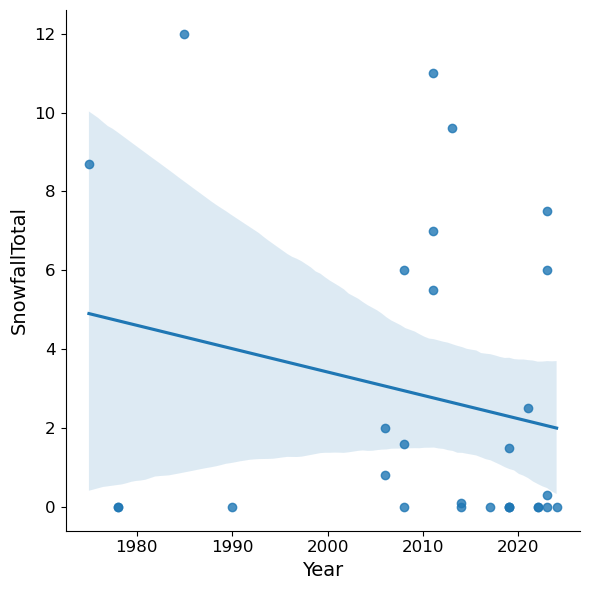

In [19]:
seaborn.lmplot( x="Year", y="SnowfallTotal", data=closure_weather, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


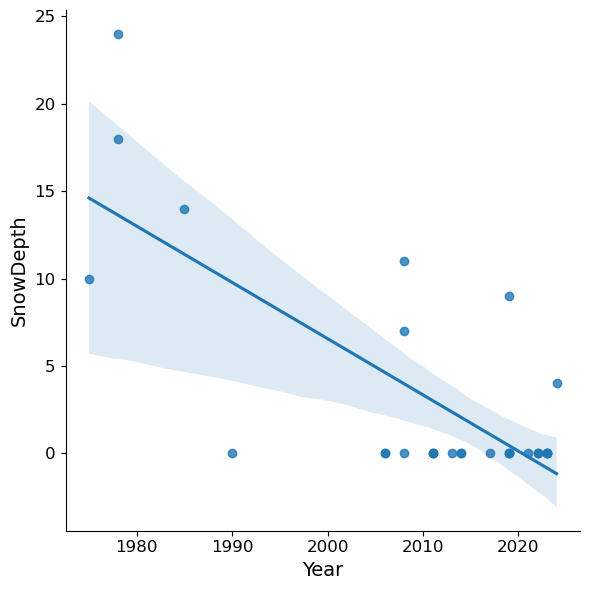

In [20]:
seaborn.lmplot( x="Year", y="SnowDepth", data=closure_weather, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


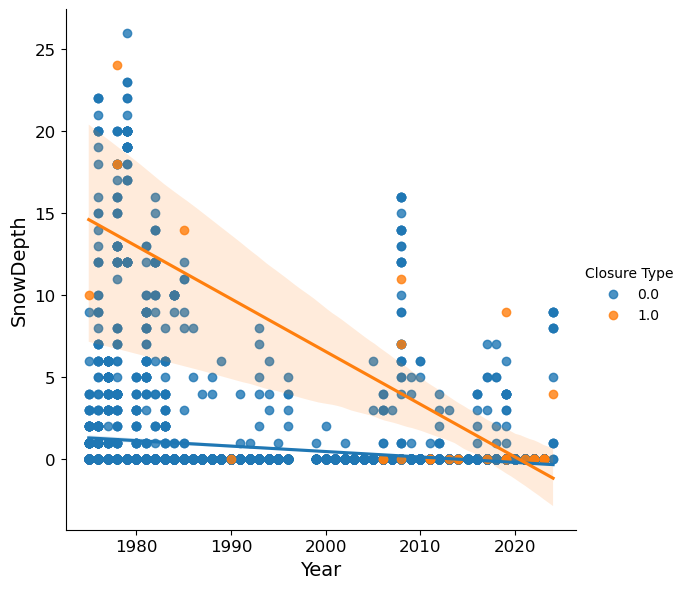

In [21]:
seaborn.lmplot( x="Year", y="SnowDepth", hue ="Closure Type",data = full, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


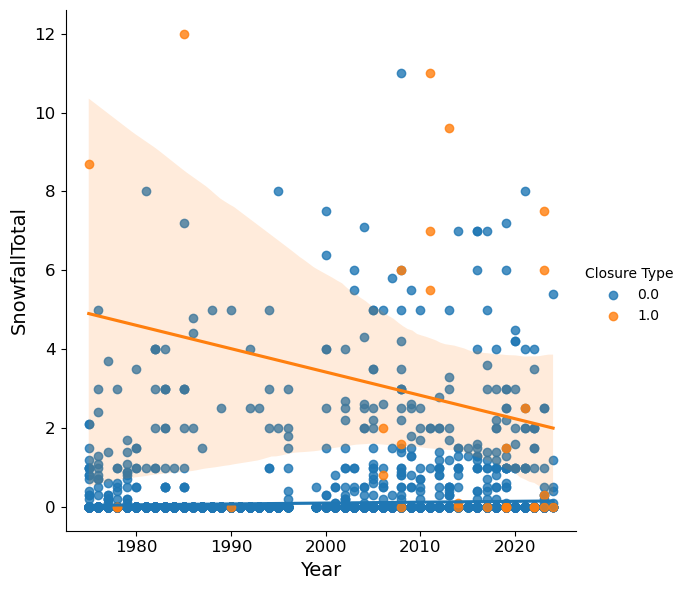

In [22]:
seaborn.lmplot( x="Year", y="SnowfallTotal", hue ="Closure Type",data = full, height = 6)

<Axes: xlabel='Day', ylabel='Month'>

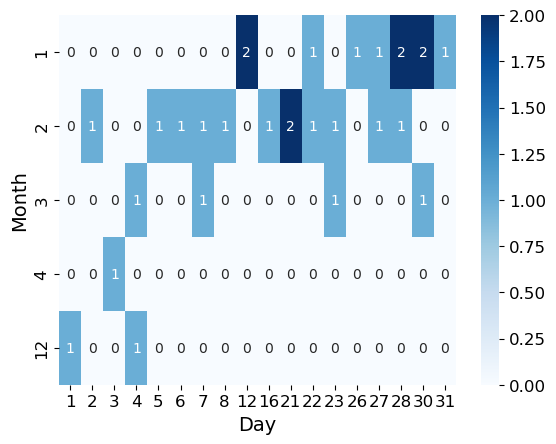

In [23]:
pivot_table = closure_weather.pivot_table(index = "Month", columns = "Day", aggfunc='size', fill_value=0)
seaborn.heatmap(pivot_table, annot=True, cmap='Blues', fmt ='d')

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


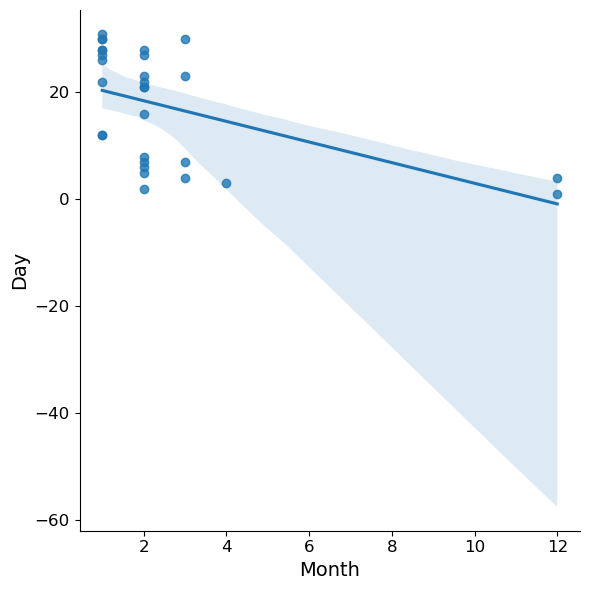

In [24]:
seaborn.lmplot( x="Month", y="Day", data=closure_weather, height=6)

In [25]:
full.corr()['Closure Type'].sort_values()

MaxTemp                    -0.063008
Previous_MinTemp           -0.053827
MinTemp                    -0.053056
Month                      -0.052230
Previous_MaxTemp           -0.052014
3DayVector_MaxTemp         -0.020436
3DayVector_MinTemp         -0.011511
Fog/IceFog/FreezingFog     -0.010299
Ice/Sleet                  -0.004945
Hail                       -0.001766
WaterEqGroundSnow          -0.001625
MultidaySnowfallTotal      -0.001205
Day of the Week             0.007007
Day                         0.016621
Previous_SnowDepth          0.043348
PrecipitationTotal          0.046908
School Year                 0.048217
Year                        0.049438
Thunder                     0.050351
Previous_SnowfallTotal      0.057430
HighWinds                   0.063597
Glaze                       0.072807
SnowDepth                   0.075885
3DayVector_SnowDepth        0.090775
Snow Days This Year         0.127111
3DayVector_SnowfallTotal    0.161443
Previous Early Dismissal    0.213558
S

In [26]:
ready = full.drop(columns=['3DayVector_MaxTemp', '3DayVector_MinTemp', 'Day','Day of the Week' , 'Hail', 'Ice/Sleet', 'MultidaySnowfallTotal', 'Fog/IceFog/FreezingFog', 'Station', 'WaterEqGroundSnow', 'Previous_SnowDepth','School Year', 'Year', 'PrecipitationTotal' ])

In [27]:
ready.corr()['Closure Type'].sort_values()

MaxTemp                    -0.063008
Previous_MinTemp           -0.053827
MinTemp                    -0.053056
Month                      -0.052230
Previous_MaxTemp           -0.052014
Thunder                     0.050351
Previous_SnowfallTotal      0.057430
HighWinds                   0.063597
Glaze                       0.072807
SnowDepth                   0.075885
3DayVector_SnowDepth        0.090775
Snow Days This Year         0.127111
3DayVector_SnowfallTotal    0.161443
Previous Early Dismissal    0.213558
SnowfallTotal               0.270975
Closure Type                1.000000
Name: Closure Type, dtype: float64

<Axes: >

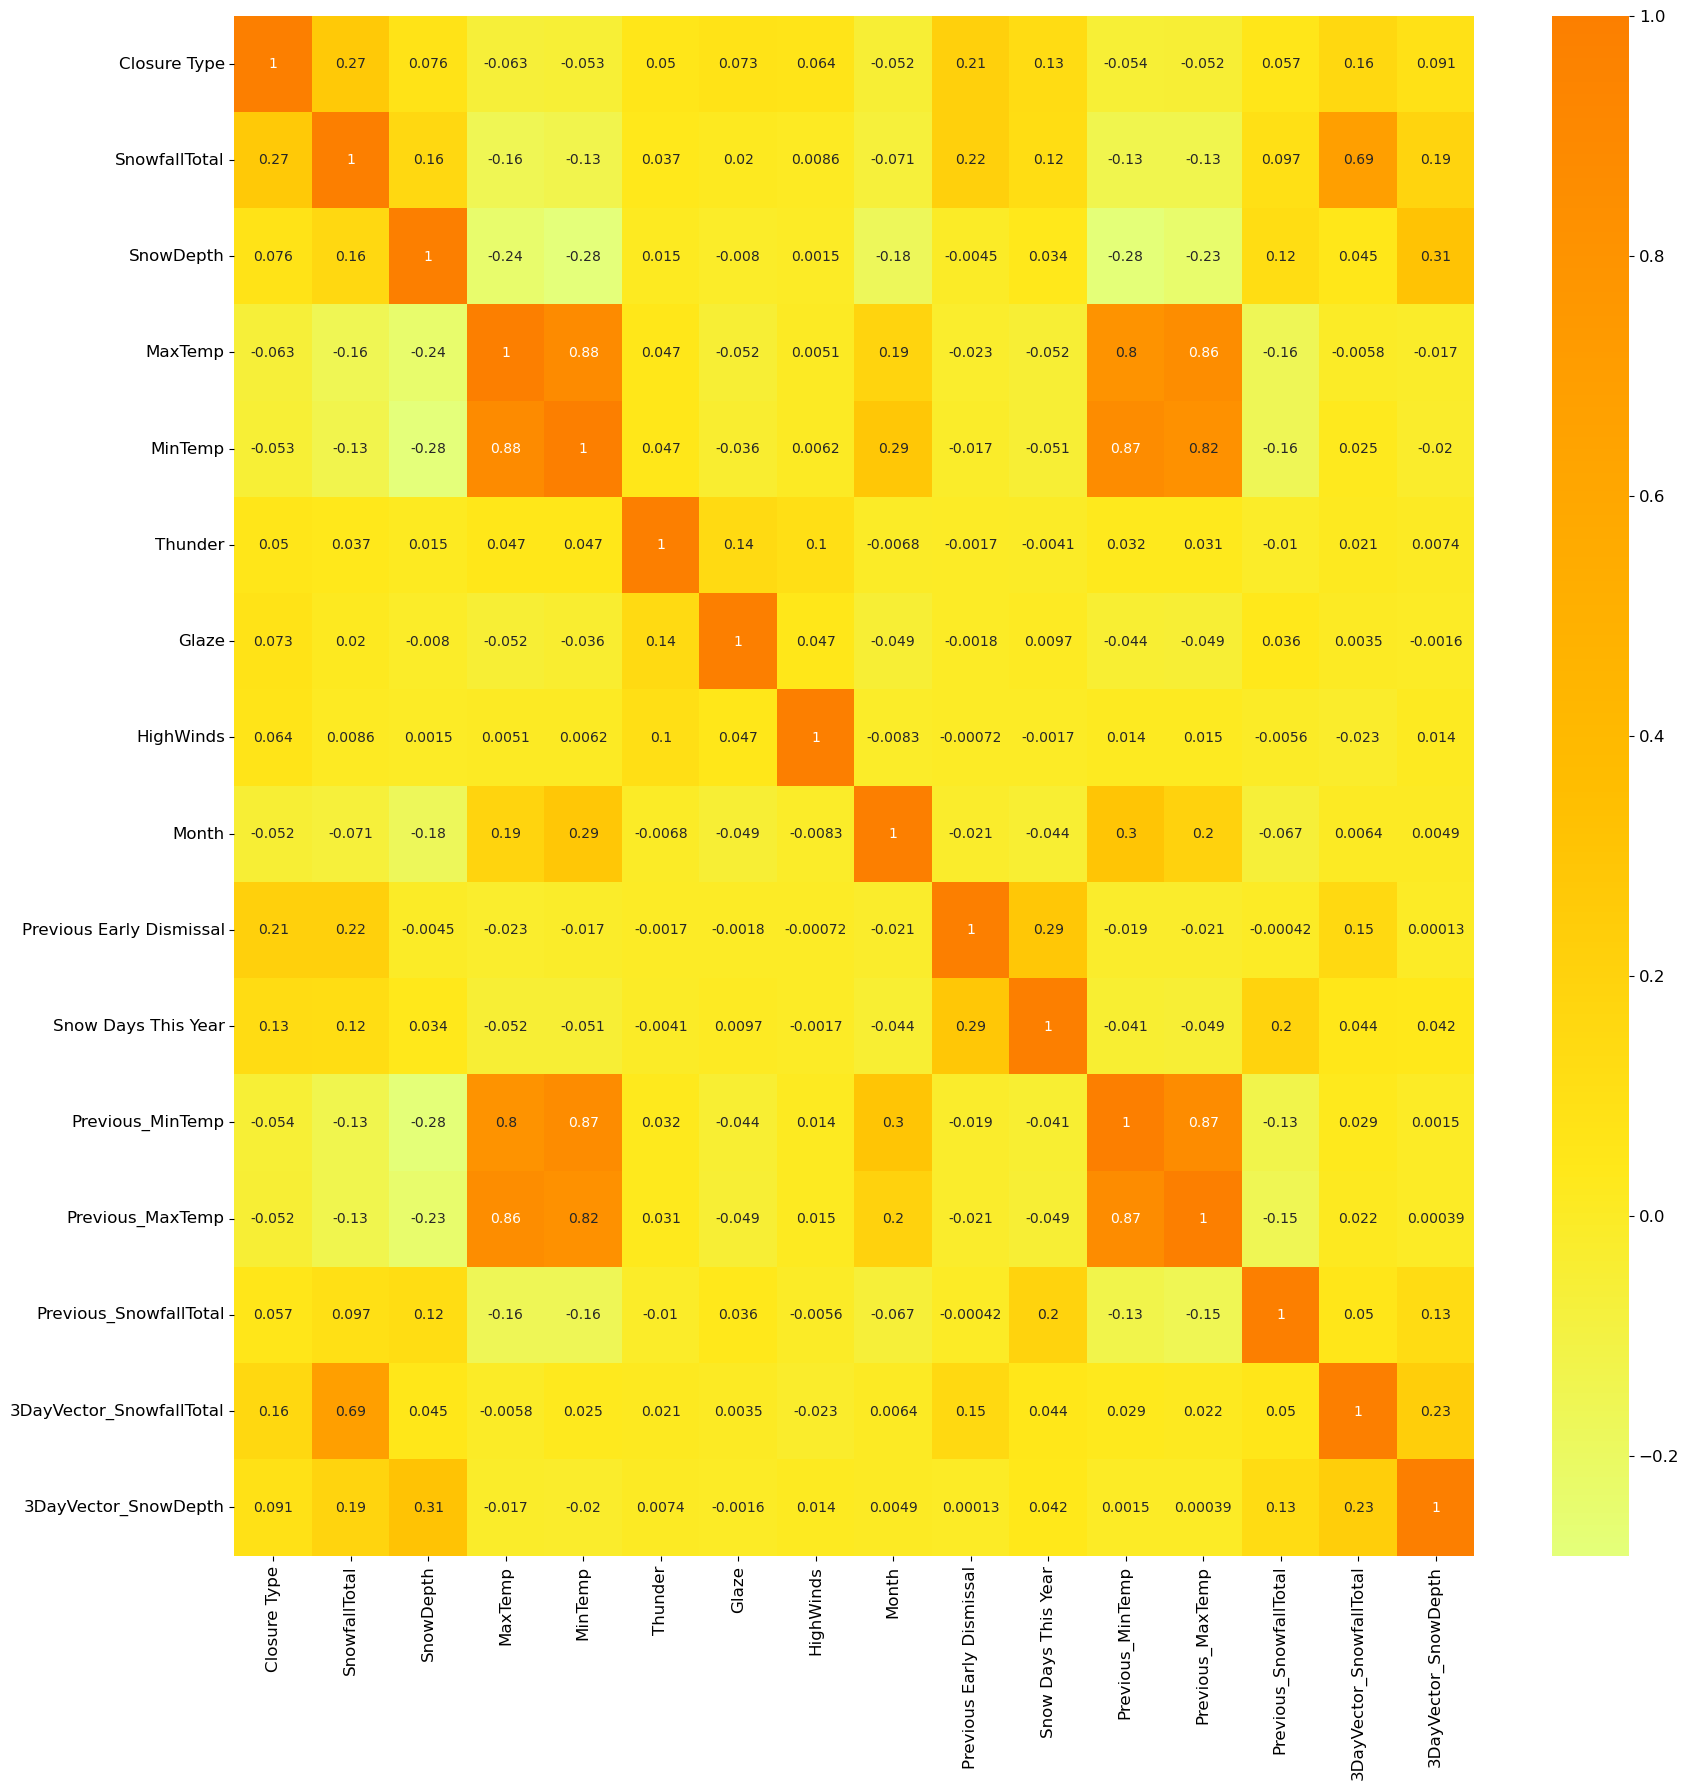

In [28]:
plt.figure(figsize=(20,20))
corr = ready.corr()
seaborn.heatmap(corr, cmap = 'Wistia', annot= True)

# data splitting

In [29]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.8880215947855751


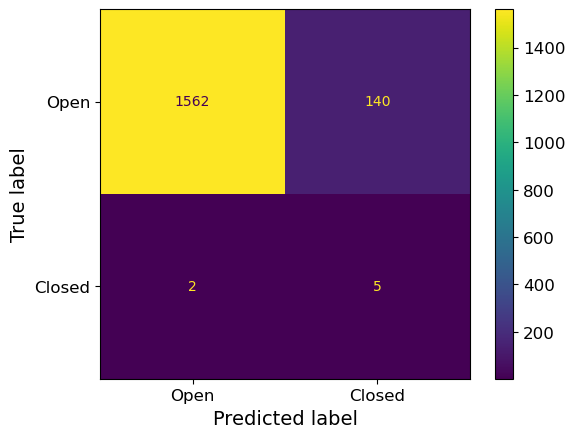

Test set accuracy score for Logistic Regression Model is  0.9169104739613809
Test set recall score for Logistic Regression Model is  0.7142857142857143
Test set precision score for Logistic Regression Model is  0.034482758620689655
Test set F1 score for Logistic Regression Model is  0.06578947368421054


In [32]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree

In [33]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [34]:
dt_model = DecisionTreeClassifier(criterion= 'entropy', max_depth= None, min_samples_leaf= 1, min_samples_split=5, random_state=42)
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9904407285575049


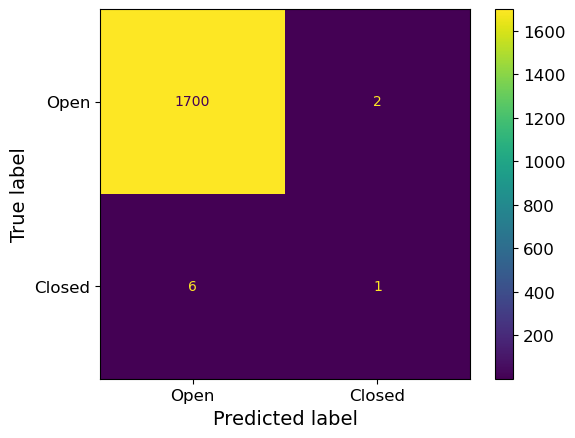

Test set accuracy score for Decision Tree Model is  0.9953188999414863
Test set recall score for Decision Tree Model is  0.14285714285714285
Test set precision score for Decision Tree Model is  0.3333333333333333
Test set F1 score for Decision Tree Model is  0.2


In [35]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest

In [36]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [37]:
rnd_clf = RandomForestClassifier(n_estimators = 150, criterion = 'gini', max_depth = 5, min_samples_leaf = 1, min_samples_split =2, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9888820358187134


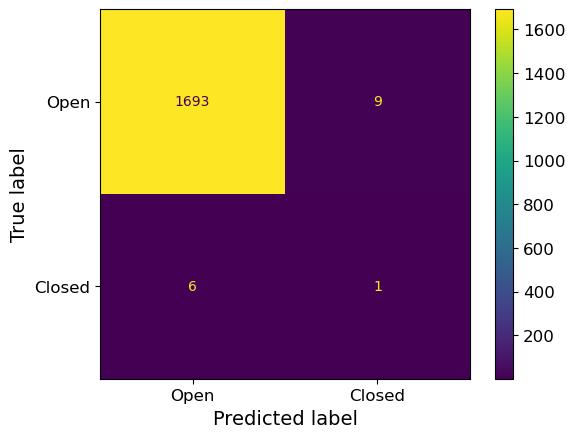

Test set accuracy score for Random Forest Model is  0.9912229373902867
Test set recall score for Random Forest Model is  0.14285714285714285
Test set precision score for Random Forest Model is  0.1
Test set F1 score for Random Forest Model is  0.11764705882352941


In [38]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3= accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3= recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3= precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13= f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)

# creating subset of just extreme weather data and school closures (more balanced data set)

In [39]:
snow = full['SnowfallTotal']>1
temp=full['MinTemp']<32
closure=full['Closure Type'] == 1

extreme_subset = full[snow|temp|closure]

extreme_subset['Closure Type'].value_counts()

Closure Type
0.0    3883
1.0      29
Name: count, dtype: int64

# data correlations and more drops

In [40]:
extreme_subset.corr()['Closure Type'].sort_values()

Month                      -0.048498
MaxTemp                    -0.043731
Previous_MinTemp           -0.025659
Previous_MaxTemp           -0.024871
MinTemp                    -0.018203
3DayVector_MaxTemp         -0.015714
Fog/IceFog/FreezingFog     -0.012082
Ice/Sleet                  -0.007971
WaterEqGroundSnow          -0.002845
Hail                       -0.002765
MultidaySnowfallTotal      -0.002109
3DayVector_MinTemp          0.003733
Day of the Week             0.010507
Day                         0.024907
Previous_SnowDepth          0.033993
Previous_SnowfallTotal      0.051192
SnowDepth                   0.066963
School Year                 0.068266
Year                        0.069560
Glaze                       0.071576
Thunder                     0.084899
PrecipitationTotal          0.089668
HighWinds                   0.090477
3DayVector_SnowDepth        0.091410
Snow Days This Year         0.124950
3DayVector_SnowfallTotal    0.162907
Previous Early Dismissal    0.212910
S

In [41]:
ready =extreme_subset.drop(columns=['3DayVector_MaxTemp',  'Day', 'Day of the Week', '3DayVector_MinTemp','Hail', 'Ice/Sleet', 'MultidaySnowfallTotal',  'Month', 'MaxTemp', 'Previous_MinTemp', 'Previous_MaxTemp', 'MinTemp','Fog/IceFog/FreezingFog','WaterEqGroundSnow', 'Previous_SnowDepth', 'Station', ])

In [42]:
ready.corr()['Closure Type'].sort_values()

Previous_SnowfallTotal      0.051192
SnowDepth                   0.066963
School Year                 0.068266
Year                        0.069560
Glaze                       0.071576
Thunder                     0.084899
PrecipitationTotal          0.089668
HighWinds                   0.090477
3DayVector_SnowDepth        0.091410
Snow Days This Year         0.124950
3DayVector_SnowfallTotal    0.162907
Previous Early Dismissal    0.212910
SnowfallTotal               0.266218
Closure Type                1.000000
Name: Closure Type, dtype: float64

# resplit data (for extreme subset)

In [43]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression (extreme subset)

In [45]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.8789997910426971


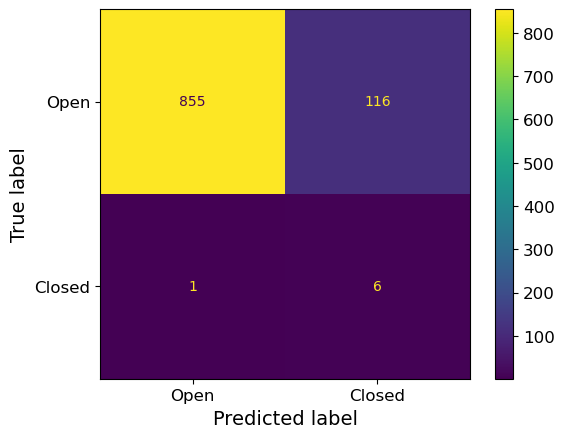

Test set accuracy score for Logistic Regression Model is  0.8803680981595092
Test set recall score for Logistic Regression Model is  0.8571428571428571
Test set precision score for Logistic Regression Model is  0.04918032786885246
Test set F1 score for Logistic Regression Model is  0.0930232558139535


In [46]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree (extreme subset)

In [47]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [48]:
dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = None, min_samples_leaf = 4, min_samples_split =2, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.965910937753941


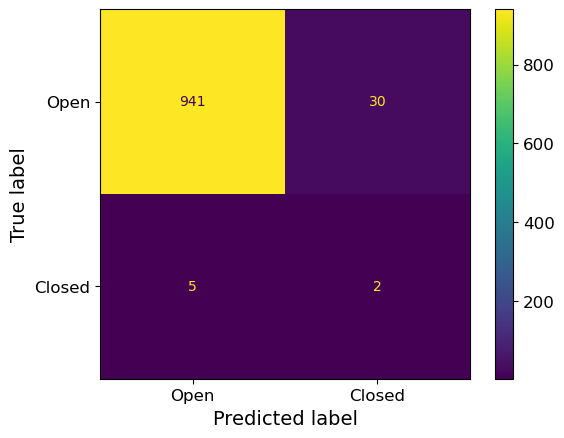

Test set accuracy score for Decision Tree Model is  0.9642126789366053
Test set recall score for Decision Tree Model is  0.2857142857142857
Test set precision score for Decision Tree Model is  0.0625
Test set F1 score for Decision Tree Model is  0.10256410256410256


In [49]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest (extreme subset)

In [50]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [51]:
rnd_clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = None, min_samples_leaf = 1, min_samples_split =2, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9873929093821827


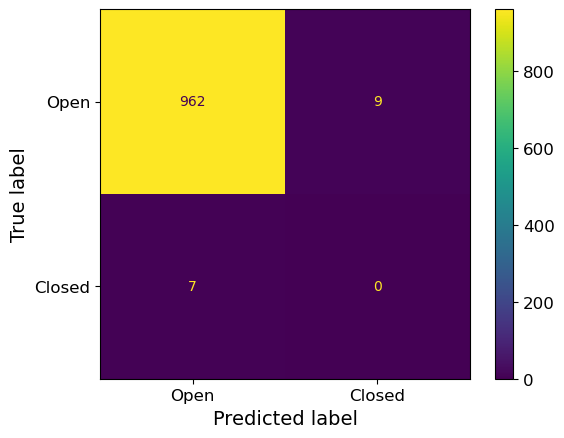

Test set accuracy score for Random Forest Model is  0.983640081799591
Test set recall score for Random Forest Model is  0.0
Test set precision score for Random Forest Model is  0.0
Test set F1 score for Random Forest Model is  0.0


In [52]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3 = recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3 = precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13 = f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)